# Phase planes of Bifurcation Graph Ko

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
os.environ['AUTO_DIR'] = '/home/contreras/Documents/Auto4Servers/compute2/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

# Defining setup for the continuations

### Defining neuron model

In [8]:
## Loading neuron model (file in the cfg folder)
model_name_p0='MTM_W_sPNaS_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
x_neuron=copy(neuron_snap)
### We will choose for the analysis this model..
model_name=model_name_p0

### Extracting Bif graph information from saved object

In [9]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

# Now we want to extract phase planes in each of the regions

### First we extract the limit cycle and the steady states for the specific currents we are interested in

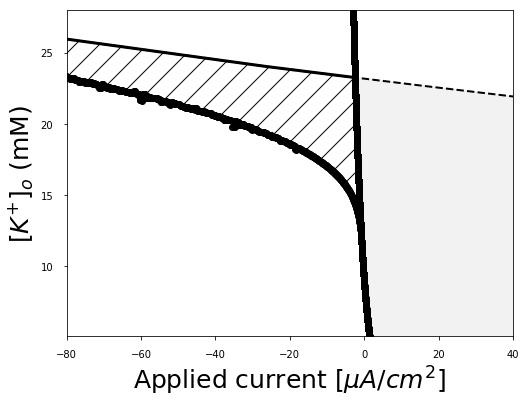

In [10]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('$[K^{+}]_o $ (mM)',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()




### Here, we choose points in the different regions to get more details on the attractors of each region

In [11]:
## Applied currents in which we are interested to get details on the continuation objects
##############################################3
I_app=-10;K_o=13.0 ### Initializing parameters for continuation

### Finding bistable region boundaries for particular Ko
lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

## Applied currents in the subthreshold, bistable, and spiking regions.
# t_I_app_specf=[lb-5.0,lb+(ub-lb)/2,ub+5.0]
t_I_app_specf=[lb-5.0,lb+2*(ub-lb)/5,ub+5.0]
# t_I_app_specf=[lb+(ub-lb)/5,lb+2*(ub-lb)/5,lb+3*(ub-lb)/5,lb+4*(ub-lb)/5]
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()

#### Running continuation with "UZR:t_I_app_specf" to define where to store the fixed points
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -10, 2: 13.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Auto4Servers/compute2/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


gfortran -L/home/contreras/Documents/Auto4Servers/compute2/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Auto4Servers/compute2/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  3689  UZ    2  -6.19868E+00   1.16416E+02  -1.16411E+02   2.37348E-06   1.33545E-07   1.00000E+00
   1  8651  UZ    3  -1.12508E+00   6.70663E+01  -6.70589E+01   3.73376E-02   1.45795E-02   9.96001E-01
   1  8890  LP    4  -1.01471E+00   6.46859E+01  -6.46782E+01   5.44717E-02   2.35308E-02   9.92679E-01
   1  9060  UZ    5  -1.12508E+00   6.29979E+01  -6.29901E+01   7.03079E-02   3.26033E-02   9.88776E-01
   1  9820  UZ    6  -6.19868E+00   5.79123E+01  -5.79041E+01   1.40653E-01   8.01344E-02   9.60074E-01
   1     1        7  -7.90602E+00   5.73436E+01  -5.73354E+01   1.50798E-01  

In [12]:
## Extracting all the steady states and stabilities for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
for r in r1_fwd_sn_I_app_specf:
    ss_stabs = [i['PT'] for i in r if i['TY name'] == 'UZ']

In [13]:
### Getting hopf from the continuation
s1HB = r1_fwd_sn_I_app_specf('HB')[0]
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    
    r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})
    
os.chdir(cwd_nonTemp)


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -10, 2: 13.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Auto4Servers/compute2/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Auto4Servers/compute2/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Auto4Servers/compute2/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  19     3  BP   32   4.01654E+02   3.75095E+01  -3.74843E+01   6.15304E-01   6.16079E-01   1.27778E-01   1.24711E+00
  19  3000       33   1.02743E+02   4.51283E+01  -9.72942E+00   5.99749E-01   9.54639E-01   2.13960E-01   1.56586E+00
  19  4007  UZ   34   3.98528E+00   5

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [14]:
## Extracting all limit cycles and stabilities for the applied currents t_I_app_specf
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')
for r in r1_period0_I_app_specf:
    lc_stabs = [i['PT'] for i in r if i['TY name'] == 'UZ']

# Results: Phase planes in each of the regions

In [15]:
### Importing the thesis format
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


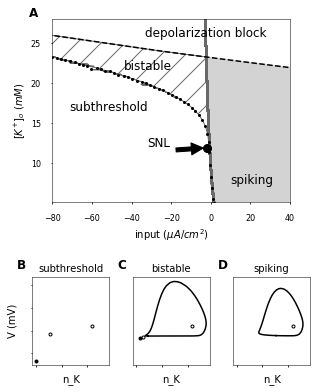

In [16]:
###################################
### Plot bifurcation diagram with phase planes ######
###################################

plt.close("all")
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.3))
axpl = plt.subplot2grid((48,16), (0, 2), colspan=12,rowspan=25)
ax1l = plt.subplot2grid((48,16), (35, 1), colspan=4,rowspan=12)
ax1m = plt.subplot2grid((48,16), (35, 6), colspan=4,rowspan=12,sharex=ax1l,sharey=ax1l)
ax1r = plt.subplot2grid((48,16), (35, 11), colspan=4,rowspan=12,sharex=ax1l,sharey=ax1l)


xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot saddle node bifurcation, hopf and limit cycle onset
nss=20
axpl.plot(m_res_par_sn_KoIapp[s_x][::nss],m_res_par_sn_KoIapp[s_y][::nss],'o',markersize=2,color='dimgray')
axpl.plot(m_res_par_lc_KoIapp[s_x][::nss],m_res_par_lc_KoIapp[s_y][::nss],'o',markersize=2,color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### Fill the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/", edgecolor='dimgray')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='lightgrey',rasterized=True)

## Finding Co-dimension2 bifurcation
snl_ko=b[b.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
snl_iapp=bx[bx.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
axpl.plot(snl_iapp,snl_ko,'o',markersize=8,color='black')

txt0='SNL'
axpl.annotate(txt0, (snl_iapp,snl_ko),xytext=(0.4, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.1))

##### Naming the different regions
axpl.annotate('bistable', (snl_iapp,snl_ko),xytext=(0.3,0.72), textcoords='axes fraction')
axpl.annotate('spiking', (snl_iapp,snl_ko),xytext=(0.75,0.1), textcoords='axes fraction')
axpl.annotate('subthreshold', (snl_iapp,snl_ko),xytext=(0.07,0.5), textcoords='axes fraction')
axpl.annotate('depolarization block', (snl_iapp,snl_ko),xytext=(0.39,0.9), textcoords='axes fraction')

##### Plot axes
axpl.set_ylabel('${[K^{+}]}_o$ $(mM)$')
axpl.set_xlabel('input $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)



## Phase planes
ax=[ax1l,ax1m,ax1r]
t_I_app_specf_temp_ii=range(len(t_I_app_specf))
###### Plotting phase planes
for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    ### Plot nodes
    for ss_Iapp,ss_stab in zip(ss_I_app_specf,ss_stabs):
        # check if the current is similar to the specified current
        if abs(ss_Iapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
            # check stability
            if ss_stab<0:
                ax[ii_iapi_ax].plot(ss_Iapp[unames[2]],ss_Iapp['v'],'o',markersize=3,color='black')
            else:
                ax[ii_iapi_ax].plot(ss_Iapp[unames[2]],ss_Iapp['v'],'o',markersize=3,mfc='none',color='black')

    # plot limit cycles.
    for lcIapp,lc_stab in zip(lc_Iapp_specf,lc_stabs):
        # check if the current is similar to the specified current
        if lc_stab is not None and abs(lcIapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
            # check stability
            if lc_stab<0:
                ax[ii_iapi_ax].plot(lcIapp[unames[2]],lcIapp['v'],color='black')
            else:
                ax[ii_iapi_ax].plot(lcIapp[unames[2]],lcIapp['v'],'--',dashes=(4, 5),color='black')
    

    ### Defining axes            
    ax[ii_iapi_ax].set_xlabel(unames[2])
    ax[ii_iapi_ax].set_ylabel('V(mV)')
    

ax1l.set_ylabel('V (mV)', labelpad=10)
ax1l.set_yticklabels([])

ax1m.get_yaxis().set_visible(False)
ax1r.get_yaxis().set_visible(False)

ax1l.set_xticklabels([])
ax1m.set_xticklabels([])
ax1r.set_xticklabels([])

### Naming phase planes
ax1l.set_title('subthreshold',fontsize=matplotlib.rcParams["axes.labelsize"])
ax1m.set_title('bistable',fontsize=matplotlib.rcParams["axes.labelsize"])
ax1r.set_title('spiking',fontsize=matplotlib.rcParams["axes.labelsize"])

### Including tags
ax_4tag=[axpl,ax1l,ax1m,ax1r]
import string
for n, axs in enumerate(ax_4tag):
    if n==0:
        axs.text(-0.1, 1.01, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')
    if n==1 or n==2 or n==3:
        axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')



plt.show()


## Simulating a noisy realization of the neuron dynamics with mean Iapp = t_app_specf

In [17]:
import sympy, scipy, brian2, matplotlib, brianutils
from brianutils import units

### Noise only in the voltage dimension
sii=0.5#\muA
sigma_v=[sii,0,0,0] 
neuron_fromgen_4sim=copy(x_neuron)
num_neurons=500
for ii_iapi in [range(len(t_I_app_specf))[1]]:
    #### Creating object to store dynamics
    d_save_sim={}
    I_app=t_I_app_specf[ii_iapi]
    bifpar={}
    bifpar[strIapp] = [str(t_I_app_specf[ii_iapi])+"* uA/cm2"]
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
    if os.path.isfile('./Data/'+name+'.pkl'):
        print(name+' exists!')
        f=open('./Data/'+name+'.pkl', 'rb')
        d_save_sim=pickle.load(f)
        limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
        tau_lc=d_save_sim['Dyn_Sys_Properties']['tau_lc']
        saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
        node=d_save_sim['Dyn_Sys_Properties']['stable']
        unstable_node=d_save_sim['Dyn_Sys_Properties']['unstable_node']
        l0=d_save_sim['Dyn_Sys_Properties']['l0']
        lam0=d_save_sim['Dyn_Sys_Properties']['lam0']

        s_results=d_save_sim['s_results']
        v_results=d_save_sim['v_results']
        fp_event_a=d_save_sim['fp_event']
        spikes_a=d_save_sim['spikes']
        M=d_save_sim['model']
    else:
        print('no File called '+name+' exists.... :()')
        from sympy.utilities.lambdify import lambdify
        from numpy import linalg as LA
        #########################################################
        #### Function to adjust Jmat dimensions for eigenvalue calculation..
        #########################################################
        def fixing_jmat(Jmat):
            m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
            for i in range(len(Jmat)):
                for j in range(len(Jmat)):
                    if 'array' in str(type(Jmat[i][j])):
                        m_JMat[i][j]=Jmat[i][j]
                    else:
                        m_JMat[i][j]=np.array([Jmat[i][j]])

            m_JMat = [np.concatenate(j) for j in m_JMat]
            return m_JMat
        ########################################
        ########## Finding Dyn sys properties.
        autobifpart={}
        autobifpart[strIapp] = t_I_app_specf[ii_iapi]
        autobifpart['K_o'] = K_o
        var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
        ########################################
        ##### Finding limit cycle. #############
        ########################################
        limit_cycle=[]
        tau_lc=[]
        for lcIapp,lc_stab in zip(lc_Iapp_specf,lc_stabs):
            # check if the current is similar to the specified current
            if lc_stab is not None and abs(lcIapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
                # check stability
                if lc_stab<0:
                    limit_cycle=lcIapp.coordarray
                    tau_lc=lcIapp.PAR['period']

        node=[]
        saddle=[]
        unstable_node=[]
        ########################################
        ##### Finding saddle node and stable node
        ########################################
        for ss_Iapp,ss_stab in zip(ss_I_app_specf,ss_stabs):
            # check if the current is similar to the specified current
            if abs(ss_Iapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
                # check stability
                if ss_stab<0:
                    node=ss_Iapp.coordarray
                else:
                    u_ss=ss_Iapp.coordarray
                    v_s_par_ssi=[(k,v) for k,v in ss_Iapp.PAR.items()]
                    J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
                    Jfoo = lambdify(ss_Iapp.coordnames,J)
                    Jmat=Jfoo(*u_ss)
                    m_JMat=fixing_jmat(Jmat)
                    Jeival, Jeivect = LA.eig(m_JMat)
                    L_Jeival, L_Jeivect = LA.eig(np.matrix(m_JMat).transpose())
                    if sum(Jeival.real>0)==1:
                        saddle=u_ss
                        El_saddle=L_Jeivect
                        Er_saddle=Jeivect
                        lam_saddle=L_Jeival
                    else:
                        unstable_node=u_ss
        
        
        ########################################
        #### finding the unstable manifold of the saddle (l0)
        ########################################
        lam0=[]
        l0=[]
        try:
            argsort = [j for j, k in sorted(enumerate(lam_saddle), key=lambda x:x[1], reverse=1)]
            lam = [lam_saddle[k] for k in argsort]
            lam0=lam[0]
            ## Extracting l0 from the left eigenvectors at the saddle node
            l0=np.concatenate(np.array(El_saddle[:,lam_saddle>0]))
            ## projecting the stable fixed point and the saddle in l0
            ys_0=np.dot(l0,saddle)[0]
            if len(node)>0:
                yn=np.dot(l0,node)[0]
                if yn>ys_0:
                    l0=-l0
                    ys_0=np.dot(l0,saddle)[0]
                    yn=np.dot(l0,node)[0]
        except:
            pass


        ########################################
        #### Storing dyn sys properties
        ########################################
        d_save_sim['Dyn_Sys_Properties']={}
        d_save_sim['Dyn_Sys_Properties']['limit_cycle']=limit_cycle
        d_save_sim['Dyn_Sys_Properties']['tau_lc']=tau_lc
        d_save_sim['Dyn_Sys_Properties']['saddle']=saddle
        d_save_sim['Dyn_Sys_Properties']['stable']=node
        d_save_sim['Dyn_Sys_Properties']['unstable_node']=unstable_node
        d_save_sim['Dyn_Sys_Properties']['l0']=l0
        d_save_sim['Dyn_Sys_Properties']['lam0']=lam0


        ################# Loading ODEs
        neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
        M= json.load(open("cfg/"+model_name+".json"))
        M['parameters'].update(bifpar)
        M['parameters'][strIapp]=M['parameters'][strIapp][0]
        M['parameters']['K_o']=M['parameters']['K_o'][0]
        M["definitions"]["I_app"] = "(I_appi - sig*xi)"
        M["parameters"].pop("I_app")
        M["parameters"]["I_appi"]=str(I_app)+"* uA/cm2"
        M["parameters"]["sig"]=str(sigma_v[0])+"*(uA/cm2*(ms)**.5)"
        sde0= brianutils.load_model(M)

        
        ############ Creating fixed point visit event..
        str_fp_event=''
        cc=0
        for i_s in var:
                if i_s =='v':
                    str_fp_event=str_fp_event+"("+i_s+"*"+str(l0[cc])+"/mV)+"
                else:
                    if cc<len(var)-1:
                        str_fp_event=str_fp_event+"("+i_s+"*"+str(l0[cc])+")+"
                    else:
                        str_fp_event=str_fp_event+"("+i_s+"*"+str(l0[cc])+")-"+str(yn)+"== 0.0"
                cc+=1

        ########### Setting up brian
        brian2.defaultclock.dt=eval("0.001 * ms", units)
        neurons= brian2.NeuronGroup(num_neurons, model=sde0, method="heun",
            threshold="v>-30*mV", refractory="2*ms", namespace=units,events={'fp_event':str_fp_event})

        ## INIT STATES ##
        for k in sde0.diff_eq_names:
            if k is not "v":
                setattr(neurons,k,0.01)

        ## Random initial conditions
        vr = eval("-75*mV",units)
        vt0 = eval("-65*mV",units)
        neurons.v='rand()*(vt0-vr)+vr'


        ### Monitors
        spikes = brian2.SpikeMonitor(neurons)
        states=brian2.StateMonitor(neurons,sde0.diff_eq_names,record=True,dt=eval("0.01*ms",units))
        fp_event = brian2.EventMonitor(neurons, 'fp_event')
        monitors = [spikes,states,fp_event]
        ### Network definition
        networkx= brian2.Network(neurons) # , states
        ### running for some time to let the system converge to ss
        networkx.run(eval("1*second",units), report='text')
        #### adding monitors
        networkx.add(monitors)
        #### run for the whole time
        networkx.run(eval("5*second",units), report='text')
        #### storing simulation results in matrix and saving
        s_results=[]
        v_results=[]
        for k in var:
            s_results.append(k)
            if k is not "v":
                v_results.append(getattr(states,k)[0])
            else:
                v_results.append(getattr(states,k)[0]/brian2.mV)

        s_results.append('t')
        v_results.append(getattr(states,'t')/brian2.ms-getattr(states,'t')[0]/brian2.ms)## Reseting time to the second sim
        v_results=np.array(v_results)
        fp_event_a=[]
        spikes_a=[]   
        for inneurons in range(num_neurons):
            spikes_t=spikes.t[spikes.i==inneurons]/brian2.ms-getattr(states,'t')[0]/brian2.ms
            fp_event_t=fp_event.t[fp_event.i==inneurons]/brian2.ms-getattr(states,'t')[0]/brian2.ms
            spikes_a.append(spikes_t)
            fp_event_a.append(fp_event_t)

        


INFO       Cache size for target "cython": 7520 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/contreras/.cython/brian_extensions" directory. [brian2]


SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.1250808864200001_K_o_13.0_sigma_0.5 exists!


WARNING    /home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in log
 [py.warnings]


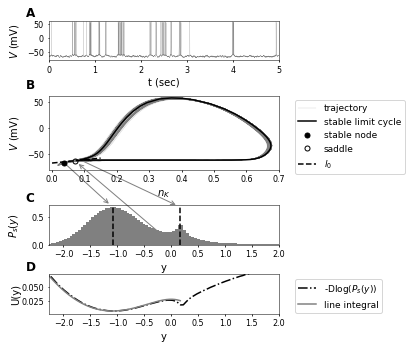

<Figure size 410.4x360 with 0 Axes>

In [20]:
from matplotlib.patches import ConnectionPatch

plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.1))

ax0 = plt.subplot2grid((52,11), (0, 0), colspan=8,rowspan=7)
ax = plt.subplot2grid((52,11), (13, 0), colspan=8,rowspan=13)
ax1 = plt.subplot2grid((52,11), (32, 0), colspan=8,rowspan=7)
ax2 = plt.subplot2grid((52,11), (44, 0), colspan=8,rowspan=7)

size_legend_font=12
##############################################################################################################
    ##### Plot voltage trace 

idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

thck=0.3## Thickness fraction for trajectories
ax0.plot(v_results[idx_t,:]/1000.0,v_results[idx_v,:],linewidth=matplotlib.rcParams['axes.linewidth']*thck,color='grey',rasterized=True)
ax0.set_xlabel(s_results[idx_t]+' (sec)',labelpad=3)
# ax0.set_ylabel(s_results[idx_v])
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim(v_results[idx_t,:][0]/1000.0,v_results[idx_t,:][-1]/1000.0)
##############################################################################################################
##### Plot trajectory in phase plane
ax.plot(v_results[idx_nk,:],v_results[idx_v,:],linewidth=matplotlib.rcParams['axes.linewidth']*thck,label='trajectory',color='grey',rasterized=True)
##### Plot attractors
ax.plot(limit_cycle[idx_nk],limit_cycle[idx_v],label='limit cycle',color='black')
ax.plot(node[idx_nk],node[idx_v],'o',markersize=5,label='stable node',color='black')
ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black')
##### Plot l0
ax.plot(np.linspace(-0.0,0.15),saddle[idx_v]+(np.linspace(-0.0,0.15)-saddle[idx_nk])*(l0[idx_v]-saddle[idx_v]),'--',label='$l_0$',color='black')

ax.set_xlim([-0.01,0.7])
ax.set_ylim([-80,62])
ax0.set_ylim([-80,62])

#### Reference points
stable=node
dlc=min(np.dot(l0,limit_cycle-saddle))
yn=np.dot(l0,node)
ys_0=np.dot(l0,saddle)
sig_eff=np.dot(sigma_v,l0)
D=sig_eff**2

### I think this might be ok.. because int(Ps(x)dx)
a,b,c=ax1.hist(np.concatenate(d_save_sim['a_y']),np.linspace(-5,5,200), normed=1, color='grey',rasterized=True)
ax1.plot([yn-ys_0, yn-ys_0],[0,max(a)],'--k')
ax1.plot([dlc, dlc],[0,max(a)],'--k')
ax1.set_xlabel('y')
ax1.set_ylabel(r'$P_s(y)$')

xyA_stable=[node[idx_nk],node[idx_v]]
xyA_saddle=[saddle[idx_nk],saddle[idx_v]]
xyA_minlc=[limit_cycle[idx_nk][np.argmin(limit_cycle[idx_nk])],limit_cycle[idx_v][np.argmin(limit_cycle[idx_nk])]]


xyB_stable=[yn-ys_0,max(a)]
xyB_saddle=[0,np.min(a[[(b>=0)*(b<1)][0][1:]])]
xyB_minlc=[dlc,max(a)]


#### To shrink graph to 2 match graph 1
dmlcnd_nk=min(limit_cycle[idx_nk])-stable[idx_nk][0]
dmlcnd_y=min(np.dot(l0,limit_cycle-saddle))-(yn-ys_0)
lob_y=(yn-ys_0)-(stable[idx_nk][0]--0.01)*dmlcnd_y/dmlcnd_nk
upb_y=lob_y+(0.7-0.01)*dmlcnd_y/dmlcnd_nk
upb_y=2.0
ax1.set_xlim([lob_y,upb_y])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
### To create arrows from one plot to the other
coordsA="data"
coordsB="data"

con_stable = ConnectionPatch(xyA=xyA_stable, xyB=xyB_stable, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax, axesB=ax1,
                      arrowstyle="->", shrinkB=5,color='grey')

con_saddle = ConnectionPatch(xyA=xyB_saddle, xyB=xyA_saddle, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax1, axesB=ax,
                      arrowstyle="->", shrinkB=5,color='grey')

con_minlc = ConnectionPatch(xyA=xyA_minlc, xyB=xyB_minlc, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax, axesB=ax1,
                      arrowstyle="->", shrinkB=5,color='grey')

ax.add_artist(con_stable)
ax1.add_artist(con_saddle)
ax.add_artist(con_minlc)



ax.set_xlabel('$'+s_results[idx_nk]+'$')
ax.set_ylabel('$V$ (mV)')





###
Uy=-np.log(a)*D

##############################################################################################################
########## T_esc_theor from line integral
##############################################################################################################
### Loading the line integral in l0 that was calculated in (p_traub_to_GIF_potentials.py)
dir_sims='./Data/'
name='d_sample_of_det_potentials_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_POTs=pickle.load(f)
f.close()
############################################################
### Finding the potential for this particular Iapp and Uy
############################################################
v_Iappi_pots=[]
v_Ko_pots=[]
for d_pot_i in d_POTs:
    v_Ko_pots.append(d_pot_i['K_o'])
    v_Iappi_pots.append(d_pot_i['I_app'])

pot_idx=np.array(range(len(v_Iappi_pots)))[v_Iappi_pots==I_app]
if len(pot_idx)==1 and v_Ko_pots[pot_idx[0]]==K_o:
    pot_idx=pot_idx[0]
elif len(pot_idx)>1:
    for ii_poti_idx in pot_idx:
        if v_Ko_pots[pii_poti_idx]==K_o:
            pot_idx=ii_poti_idx

yy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['yy_tot_t']
Uy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['Uy_tot_t']
### shifting Uy such that U(0)=0
Uy_tot_t=Uy_tot_t-Uy_tot_t[np.argmin(abs(yy_tot_t))]

Uy_tot_t=Uy_tot_t[(yy_tot_t<dlc)*(yy_tot_t>lob_y)]
yy_tot_t=yy_tot_t[(yy_tot_t<dlc)*(yy_tot_t>lob_y)]

ax2.plot(b[1:][(b[1:]>lob_y)],Uy[(b[1:]>lob_y)],'-.',color='black',label='-D$\log{(P_s(y))}$')
ax2.plot(yy_tot_t,Uy_tot_t+Uy[np.argmin(abs(b[1:]-(yn-ys_0)))]-Uy_tot_t[np.argmin(abs(yy_tot_t-(yn-ys_0)))],'gray',label='line integral')

# ax2.plot(yy_tot_t[(yy_tot_t<dlc)*(yy_tot_t>lob_y)],Uy_tot_t[(yy_tot_t<dlc)*(yy_tot_t>lob_y)],'k')


# ax2.plot([-abs(yn-ys_0), -abs(yn-ys_0)],[min(Uy),max(Uy)],'--k')
# ax2.plot([0, 0],[min(Uy),max(Uy)],'--k')
# ax2.plot([dlc, dlc],[min(Uy),max(Uy)],'--k')

ax2.set_ylabel('U(y)')
ax2.set_xlabel('y')
ax2.set_xlim([lob_y,upb_y])
# ax2.set_ylim([min(Uy[(b[1:]>lob_y)*(b[1:]<upb_y)]),max(Uy[(b[1:]>lob_y)*(b[1:]<upb_y)])])
ax2.set_ylim([min(Uy[(b[1:]>lob_y)*(b[1:]<upb_y)])-0.005,max(Uy[(b[1:]>lob_y)*(b[1:]<upb_y)])-0.015])

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

##### including a,b,c,d
v_ax=[ax0,ax,ax1,ax2]
import string
for n, axs in enumerate(v_ax):   
    axs.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    
############################################
### Aligning y labels
############################################
labely = -0.12  # axes coords
box0 =ax0.get_position()
box1 =ax.get_position()
box2 =ax1.get_position()
box3 =ax2.get_position()

ax0.yaxis.set_label_coords(labely, 0.5)
ax.yaxis.set_label_coords(labely, 0.5)
ax1.yaxis.set_label_coords(labely, 0.5)
ax2.yaxis.set_label_coords(labely, 0.5)


fig_name='l0_explanation_PyUy_illustration_'+model_name+'_intermedieate_plusTraceInTime'

md_dir={}
md_dir['Title']='l0 For bistable region'+model_name+'Ko='+str(K_o)+' for sigmav='+str(sigma_v)+' and applied currents Iapp='+str(t_I_app_specf[ii_iapi])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

plt.show()
saving_pdf_figure(fig01,'./figs/'+fig_name,md_dir,raster=300)